# What's your CV method?
- I observed the oof using k-fold, and found that the increase in the number of folds increases the oof_rmse, but the public LB decreases.

- LGBM parmeter(For the fold-12, n_estimators= 1000 learning_rate=0.1 was used as a limited time)
        n_estimators=6000,
        learning_rate=0.05,
        feature_fraction=0.7,
        subsample=0.4,
        num_leaves=40,
        metric='rmse'



- All variables are the same.

# OOF_RMSE AND Public LB
The more the fold number increases, the lower the oof_rmse and the more public lb increases.
- [2-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22526687)   
oof_rmse : 1.42 Public LB : 1.11
- [3-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22513136)   
oof_rmse : 1.35 Public LB : 1.12
- [4-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22340799)   
oof_rmse : 1.27 Public LB : 1.16
- [5-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22371767)   
oof_rmse : 1.23 Public LB : 1.17
- [6-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22371793)   
oof_rmse : 1.20 Public LB : 1.18
- [12-fold](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22371727)   
oof_rmse : 1.10 Public LB : 1.20

# Why is this happening?
Because of simple k-fold, I think it will be learned and evaluated by roughly monthly.

        Example(4-fold)
        fold0 - January ~ March 
        fold1 - April ~ June 
        fold2 - July ~ September
        fold3 - October ~ December

In [1]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import gc

directory = '/kaggle/input/ashrae-energy-prediction'
os.listdir(directory)
df_train = pd.read_csv(directory+'/train.csv')
df_train  = reduce_mem_usage(df_train)
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"])

Mem. usage decreased to 289.19 Mb (53.1% reduction)


# k-fold val_set_range

In [3]:
folds = [4, 2, 12]
for folds in folds:
    fold = KFold(n_splits=folds, shuffle=False, random_state=42)
    print('-'*50)
    print(folds,'-fold')
    for fold_, (trn_idx, val_idx)  in enumerate(fold.split(df_train, df_train['meter_reading'])):
        tr_x, tr_y = df_train.iloc[trn_idx], df_train['meter_reading'][trn_idx]
        vl_x, vl_y = df_train.iloc[val_idx], df_train['meter_reading'][val_idx]
        print('fold :', fold_)
        print('val_set_range : ',vl_x['timestamp'].min(), vl_x['timestamp'].max())    
del tr_x, tr_y, vl_x, vl_y

--------------------------------------------------
4 -fold
fold : 0
val_set_range :  2016-01-01 00:00:00 2016-04-05 21:00:00
fold : 1
val_set_range :  2016-04-05 21:00:00 2016-07-04 17:00:00
fold : 2
val_set_range :  2016-07-04 17:00:00 2016-10-02 22:00:00
fold : 3
val_set_range :  2016-10-02 22:00:00 2016-12-31 23:00:00
--------------------------------------------------
2 -fold
fold : 0
val_set_range :  2016-01-01 00:00:00 2016-07-04 17:00:00
fold : 1
val_set_range :  2016-07-04 17:00:00 2016-12-31 23:00:00
--------------------------------------------------
12 -fold
fold : 0
val_set_range :  2016-01-01 00:00:00 2016-01-31 13:00:00
fold : 1
val_set_range :  2016-01-31 13:00:00 2016-03-04 07:00:00
fold : 2
val_set_range :  2016-03-04 07:00:00 2016-04-05 21:00:00
fold : 3
val_set_range :  2016-04-05 21:00:00 2016-05-05 20:00:00
fold : 4
val_set_range :  2016-05-05 20:00:00 2016-06-04 19:00:00
fold : 5
val_set_range :  2016-06-04 19:00:00 2016-07-04 17:00:00
fold : 6
val_set_range :  2016

## Mean Meter reading

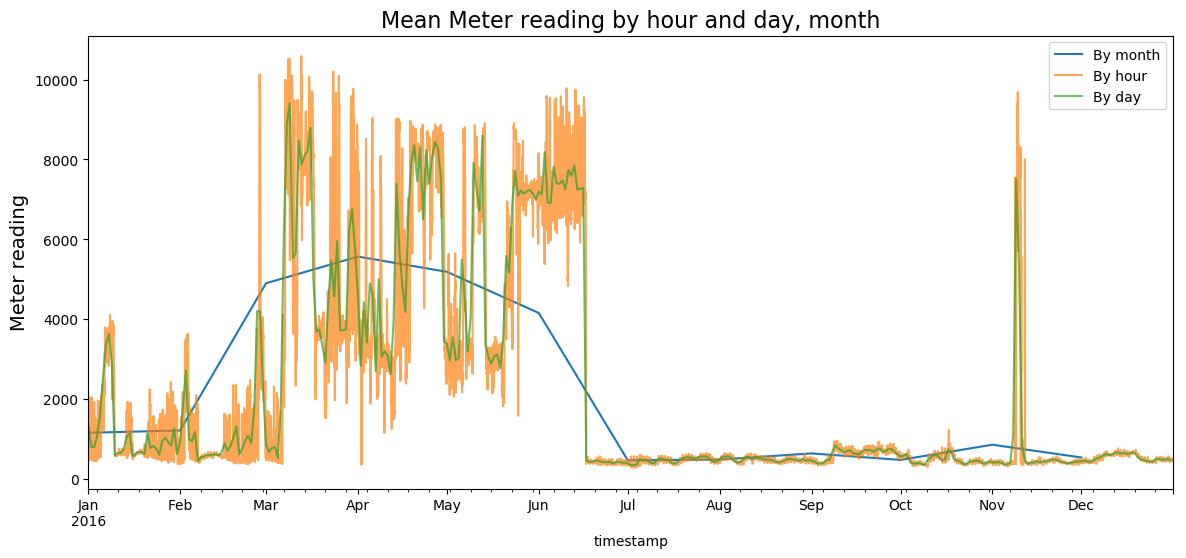

In [4]:
# Reference - https://www.kaggle.com/nroman/eda-for-ashrae
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
df_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes, label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
df_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
df_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day, month', fontsize=16);
axes.legend();

## Mean Meter reading by meter

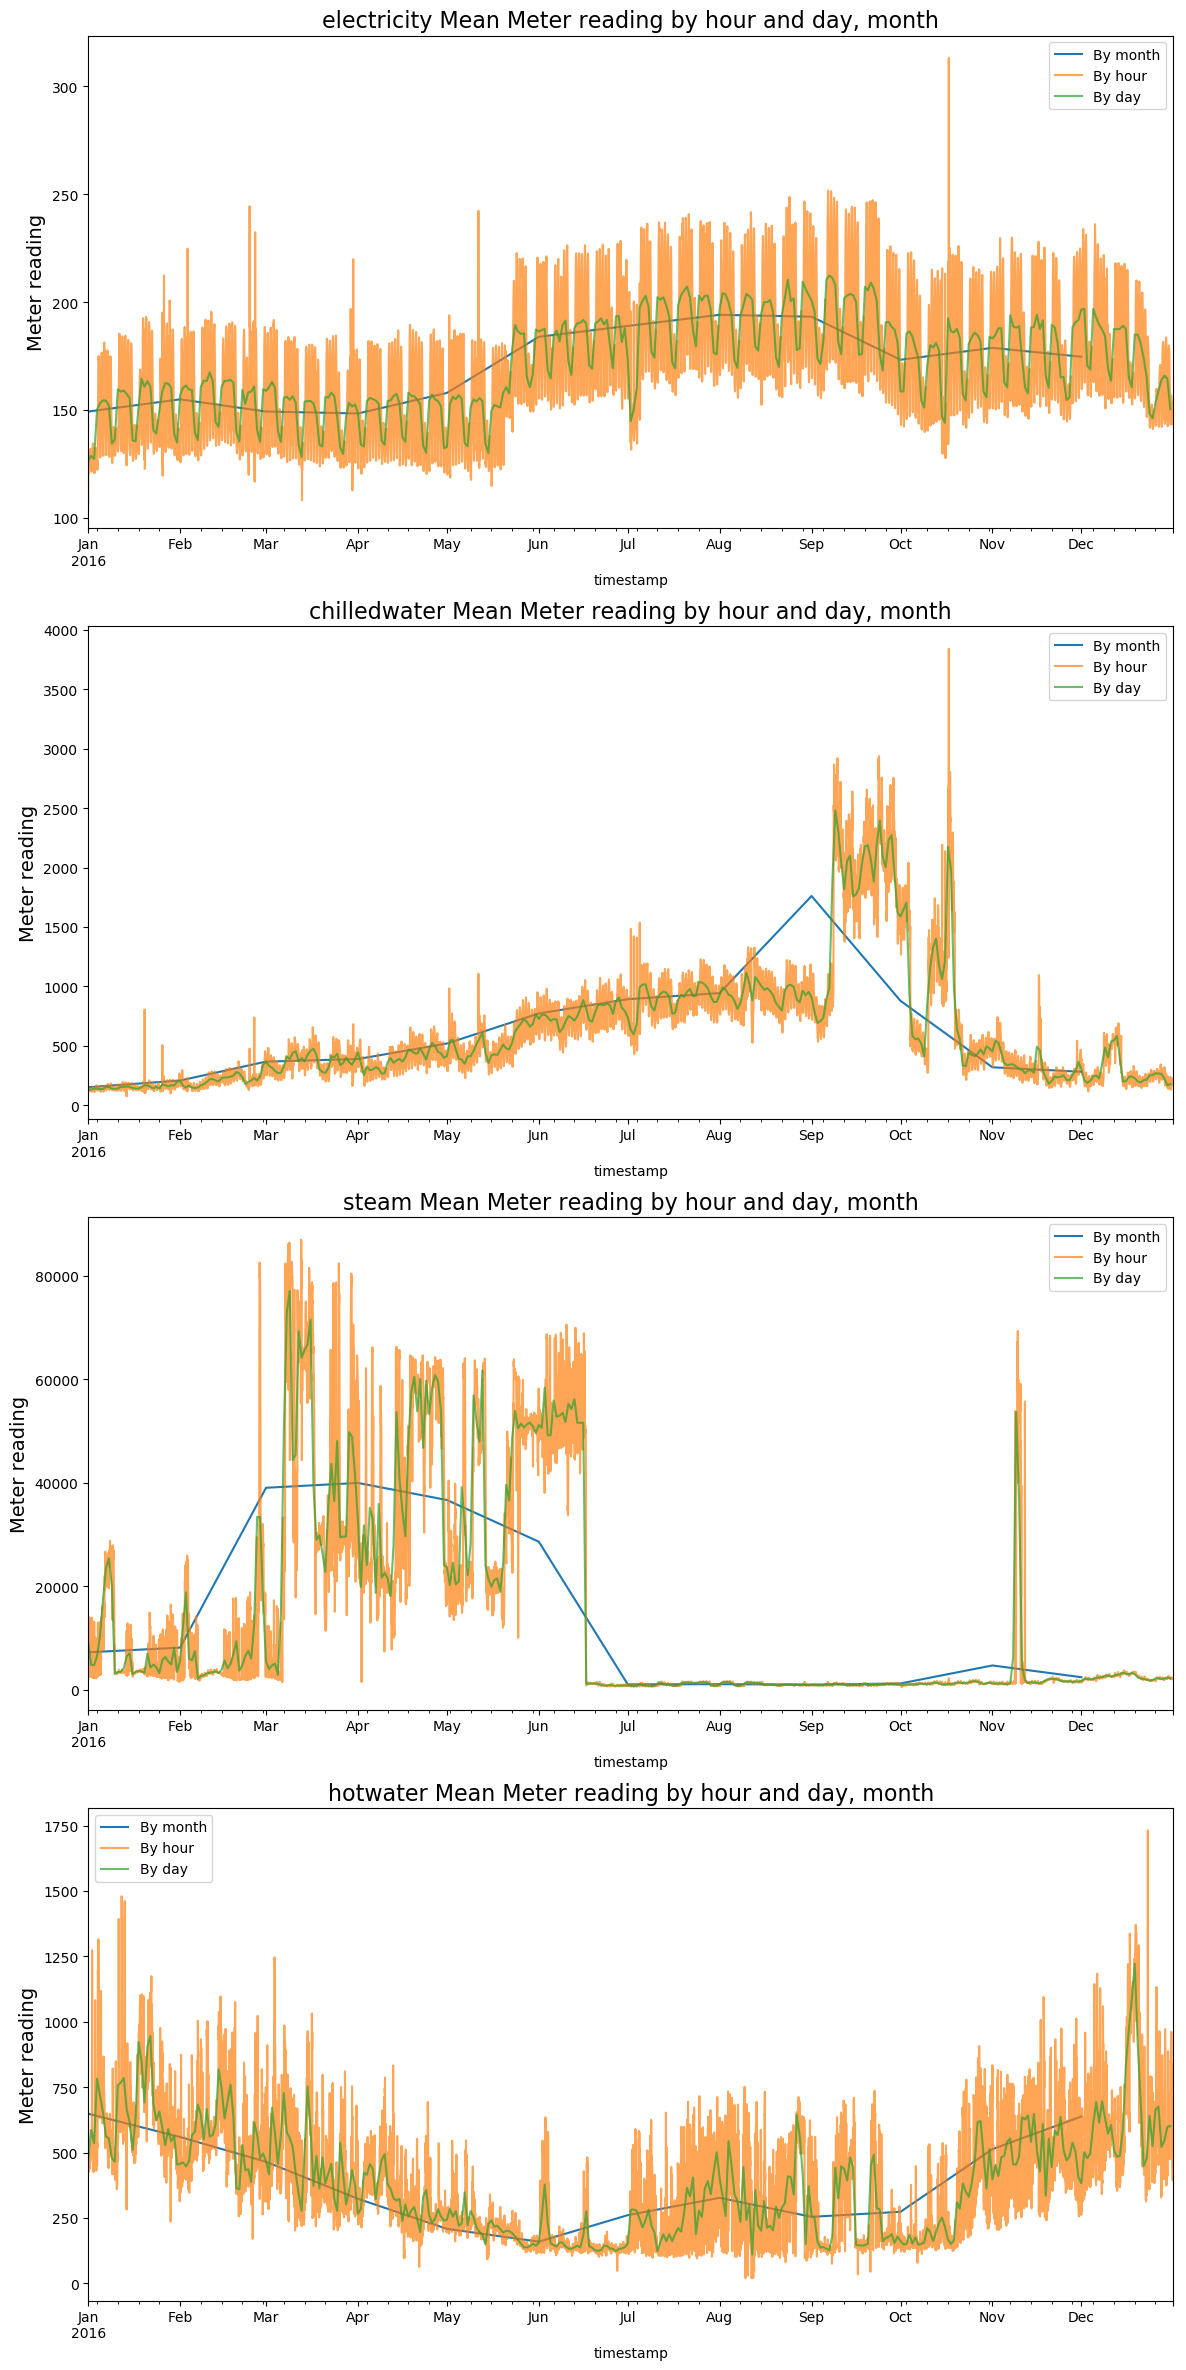

In [5]:
df_train['meter'] = df_train['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
col = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, axes = plt.subplots(4, 1, figsize=(14, 30), dpi=100)
for i, col in enumerate(col):
    train = df_train[df_train['meter']==col].copy()
    train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes[i], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i].set_title(col +' Mean Meter reading by hour and day, month', fontsize=16);
    axes[i].legend();

# 2-fold predict plot

In [6]:
del df_train
del train

df_test = pd.read_csv(directory+'/test.csv')
df_test = df_test['meter']

gc.collect()

fold2 = pd.read_csv('/kaggle/input/2fold/submission.csv')
fold2  = reduce_mem_usage(fold2)
fold2["timestamp"] = pd.to_datetime(fold2["timestamp"])
fold2 = pd.concat([fold2,df_test],axis=1)
fold2['meter'] = fold2['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
fold2.head()
gc.collect()

Mem. usage decreased to 954.38 Mb (40.0% reduction)


0

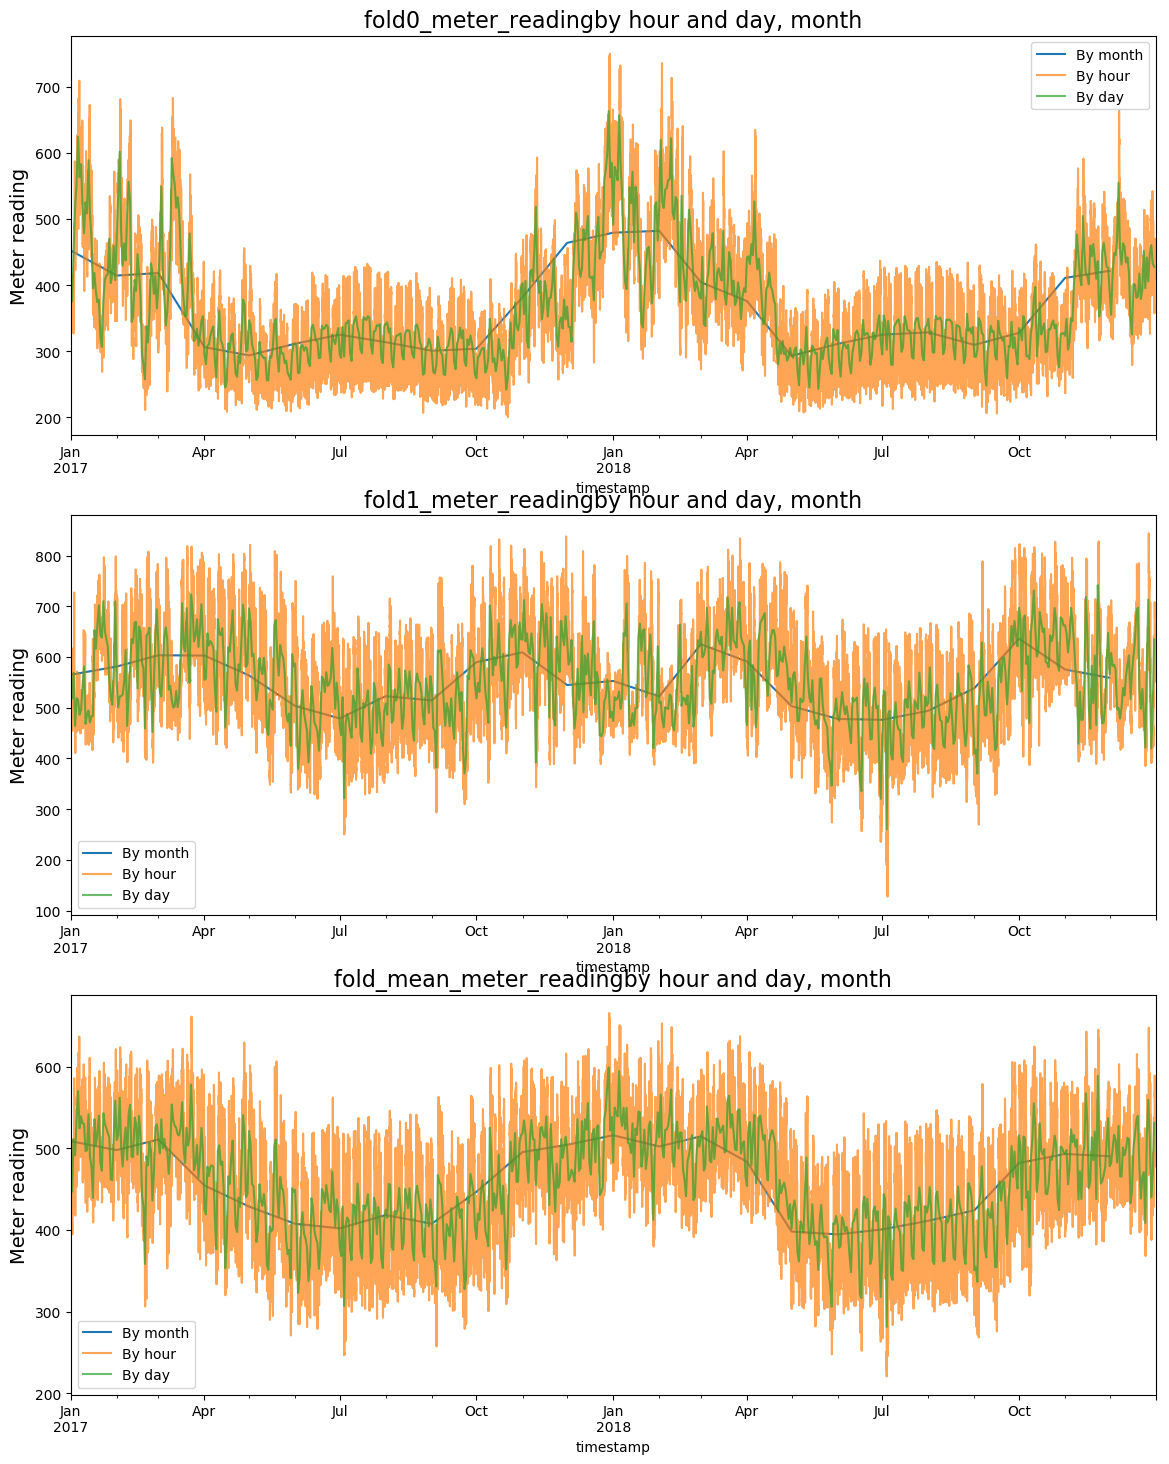

In [7]:
column = ['fold0_meter_reading', 'fold1_meter_reading','fold_mean_meter_reading']
fig, axes = plt.subplots(3, 1, figsize=(14, 18), dpi=100)
for i, col in enumerate(column):
    fold2[['timestamp', col]].set_index('timestamp').resample('M').mean()[col].plot(ax=axes[i], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    fold2[['timestamp', col]].set_index('timestamp').resample('H').mean()[col].plot(ax=axes[i], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    fold2[['timestamp', col]].set_index('timestamp').resample('D').mean()[col].plot(ax=axes[i], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i].legend();

## fold0_predict by meter

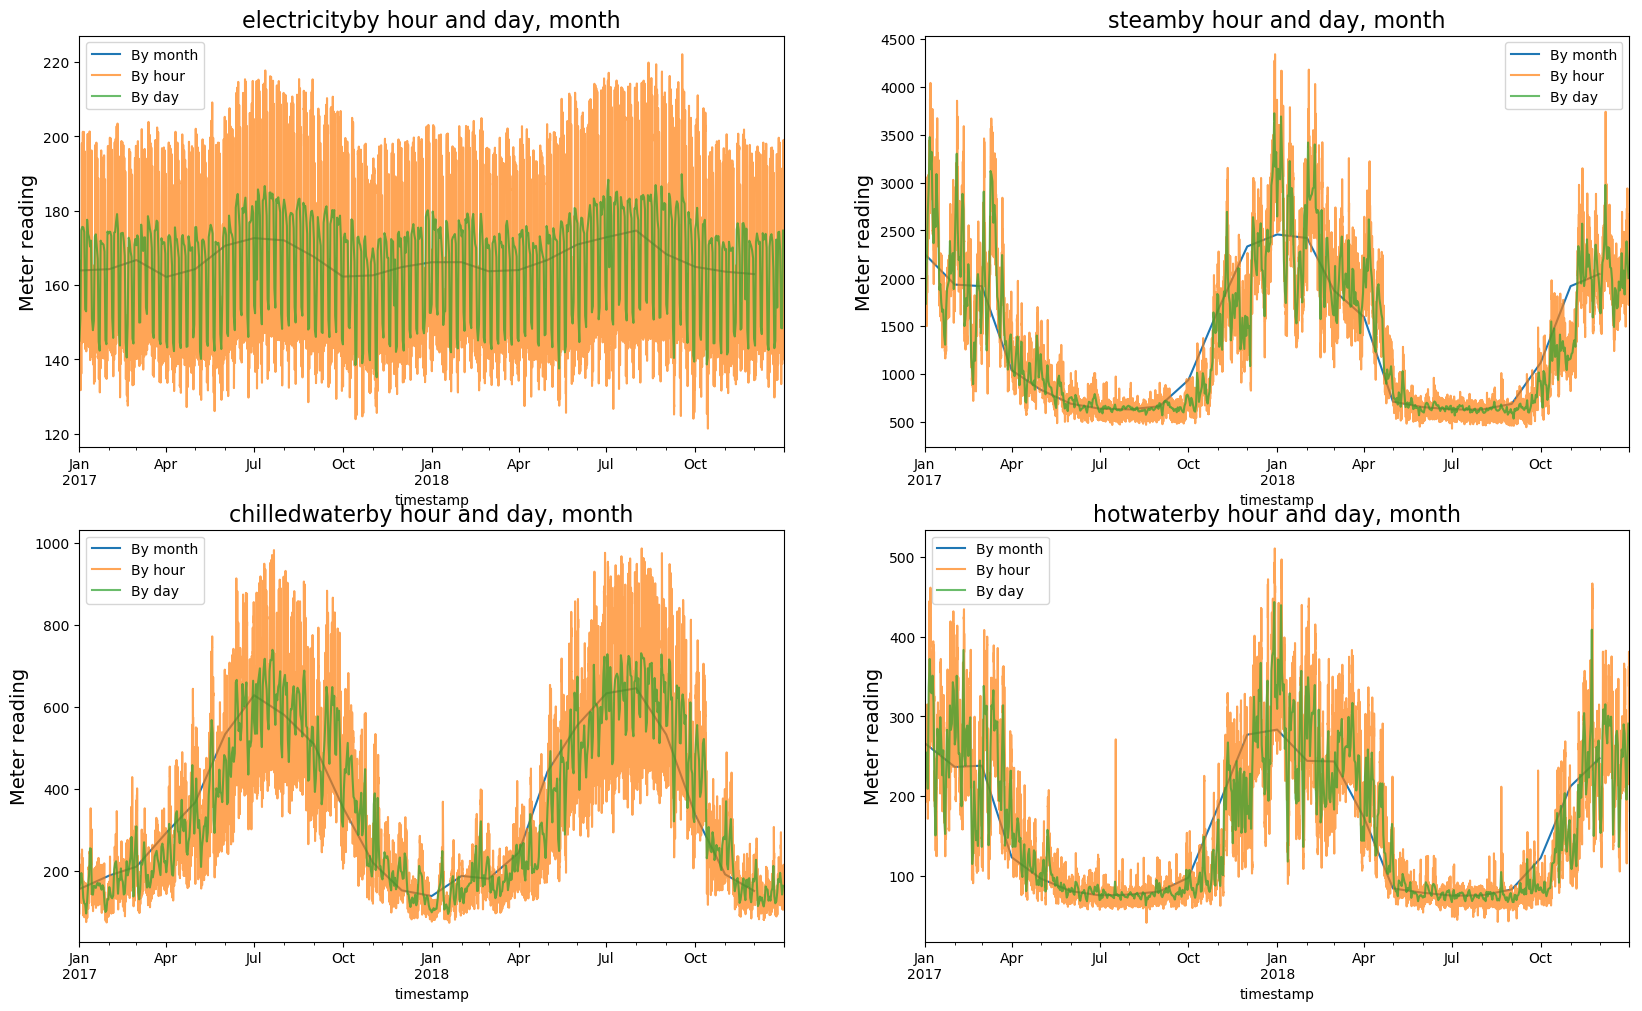

In [8]:
column = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold2[fold2['meter']==col].copy()
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('M').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('H').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('D').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold1_predict by meter

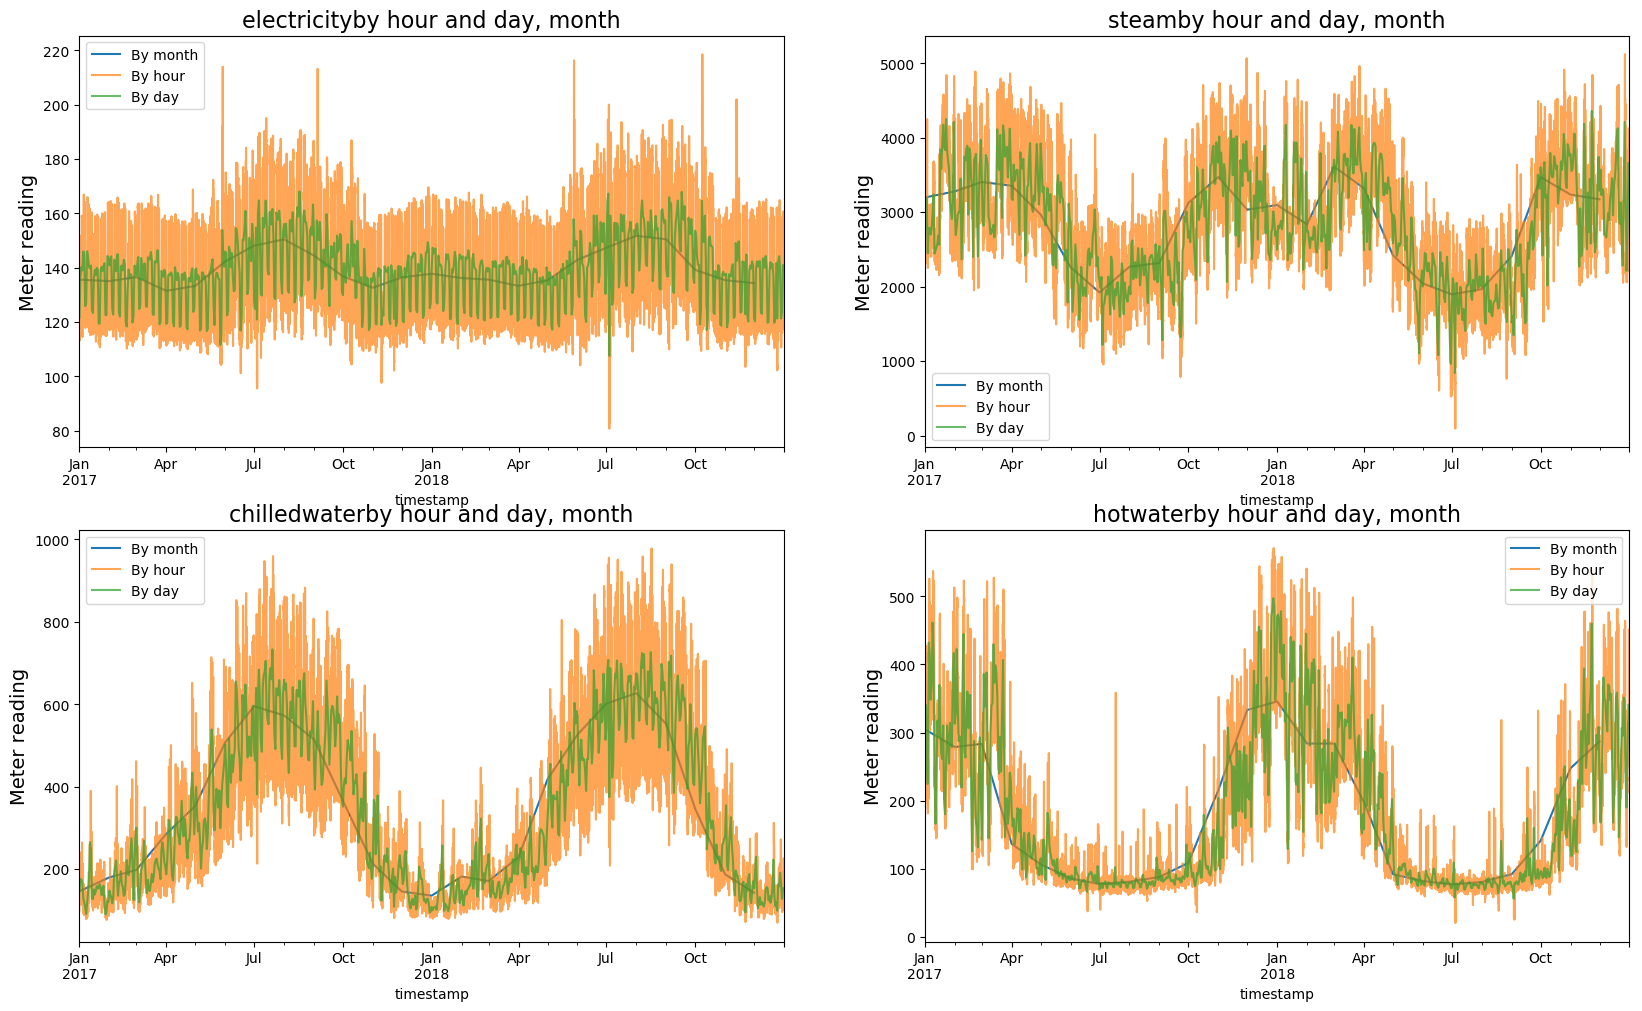

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold2[fold2['meter']==col].copy()
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('M').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('H').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('D').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold_mean_predict by meter

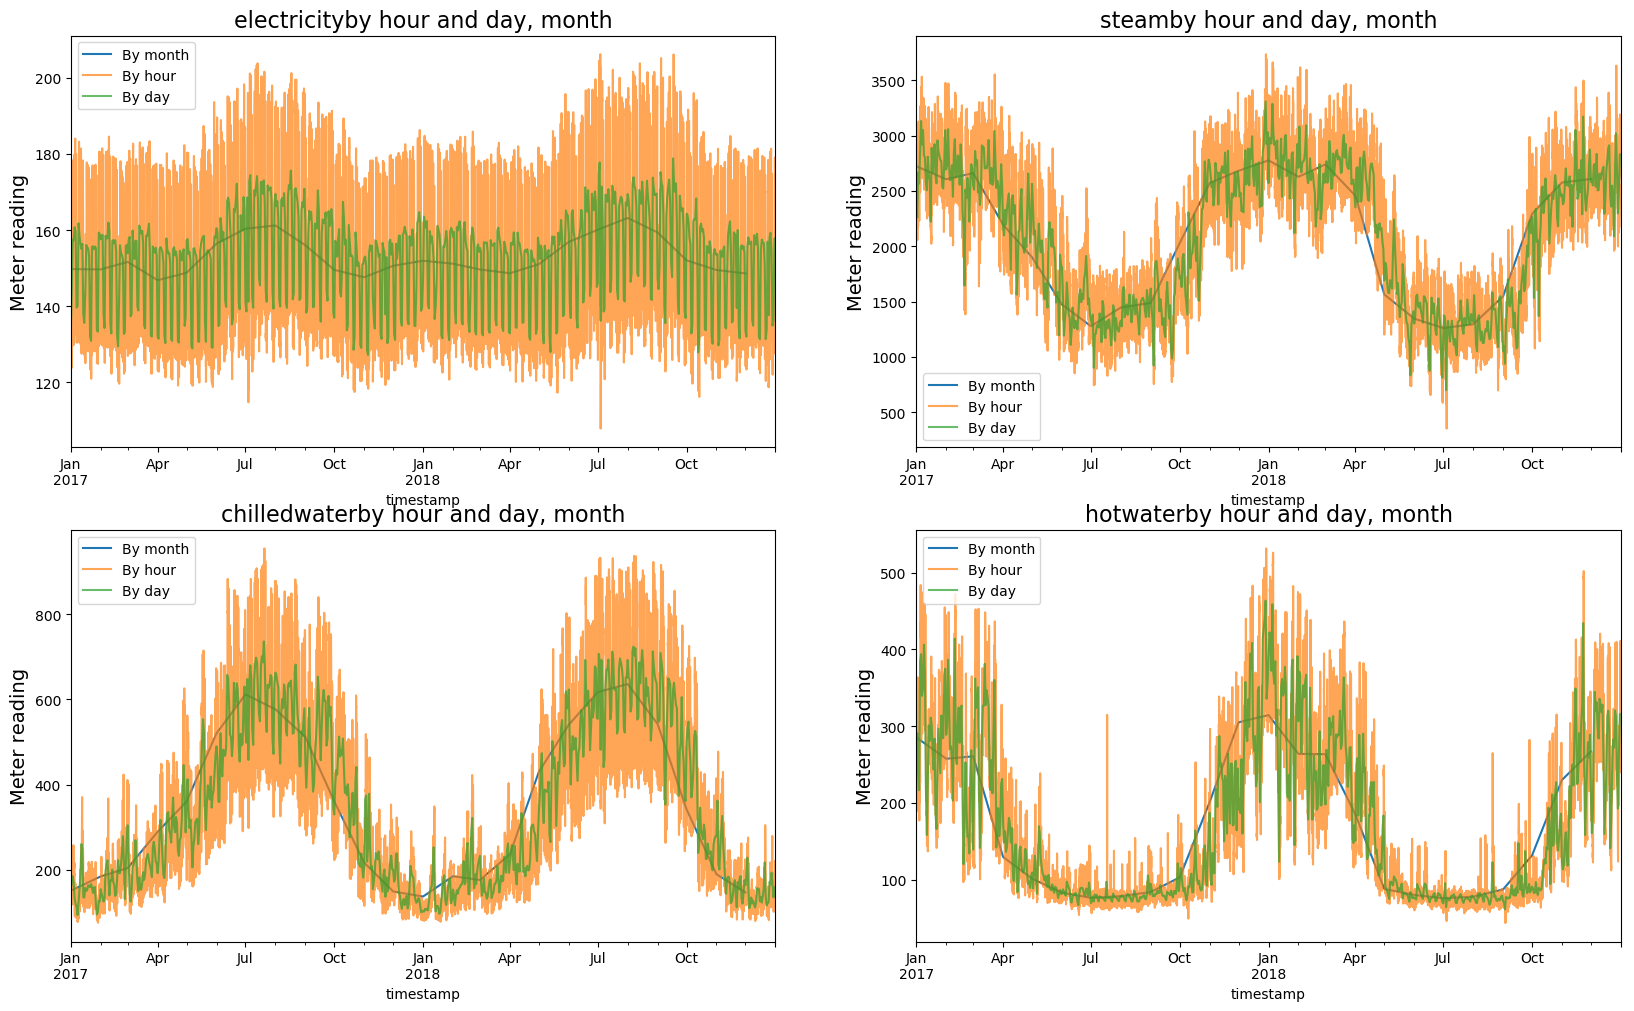

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold2[fold2['meter']==col].copy()
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('M').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('H').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('D').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

# 4-fold predict plot

In [11]:
del fold2
del train
gc.collect()

fold4 = pd.read_csv('/kaggle/input/4fold/submission.csv')
fold4  = reduce_mem_usage(fold4)
fold4["timestamp"] = pd.to_datetime(fold4["timestamp"])
fold4.head()

Mem. usage decreased to 1272.51 Mb (42.9% reduction)


row_id  timestamp  fold0_meter_reading  fold1_meter_reading  \
0       0 2017-01-01            34.111725             6.518465   
1       1 2017-01-01            17.083502             4.329663   
2       2 2017-01-01             2.494365             1.275420   
3       3 2017-01-01            38.424179            11.021185   
4       4 2017-01-01           159.384033            22.820753   

   fold2_meter_reading  fold3_meter_reading  fold_mean_meter_reading  
0             2.814975             0.314074                10.939810  
1             2.455231             0.382815                 6.062803  
2             0.353911             0.073052                 1.049187  
3             2.898086             0.256915                13.150091  
4             3.715248             0.737280                46.664330

273

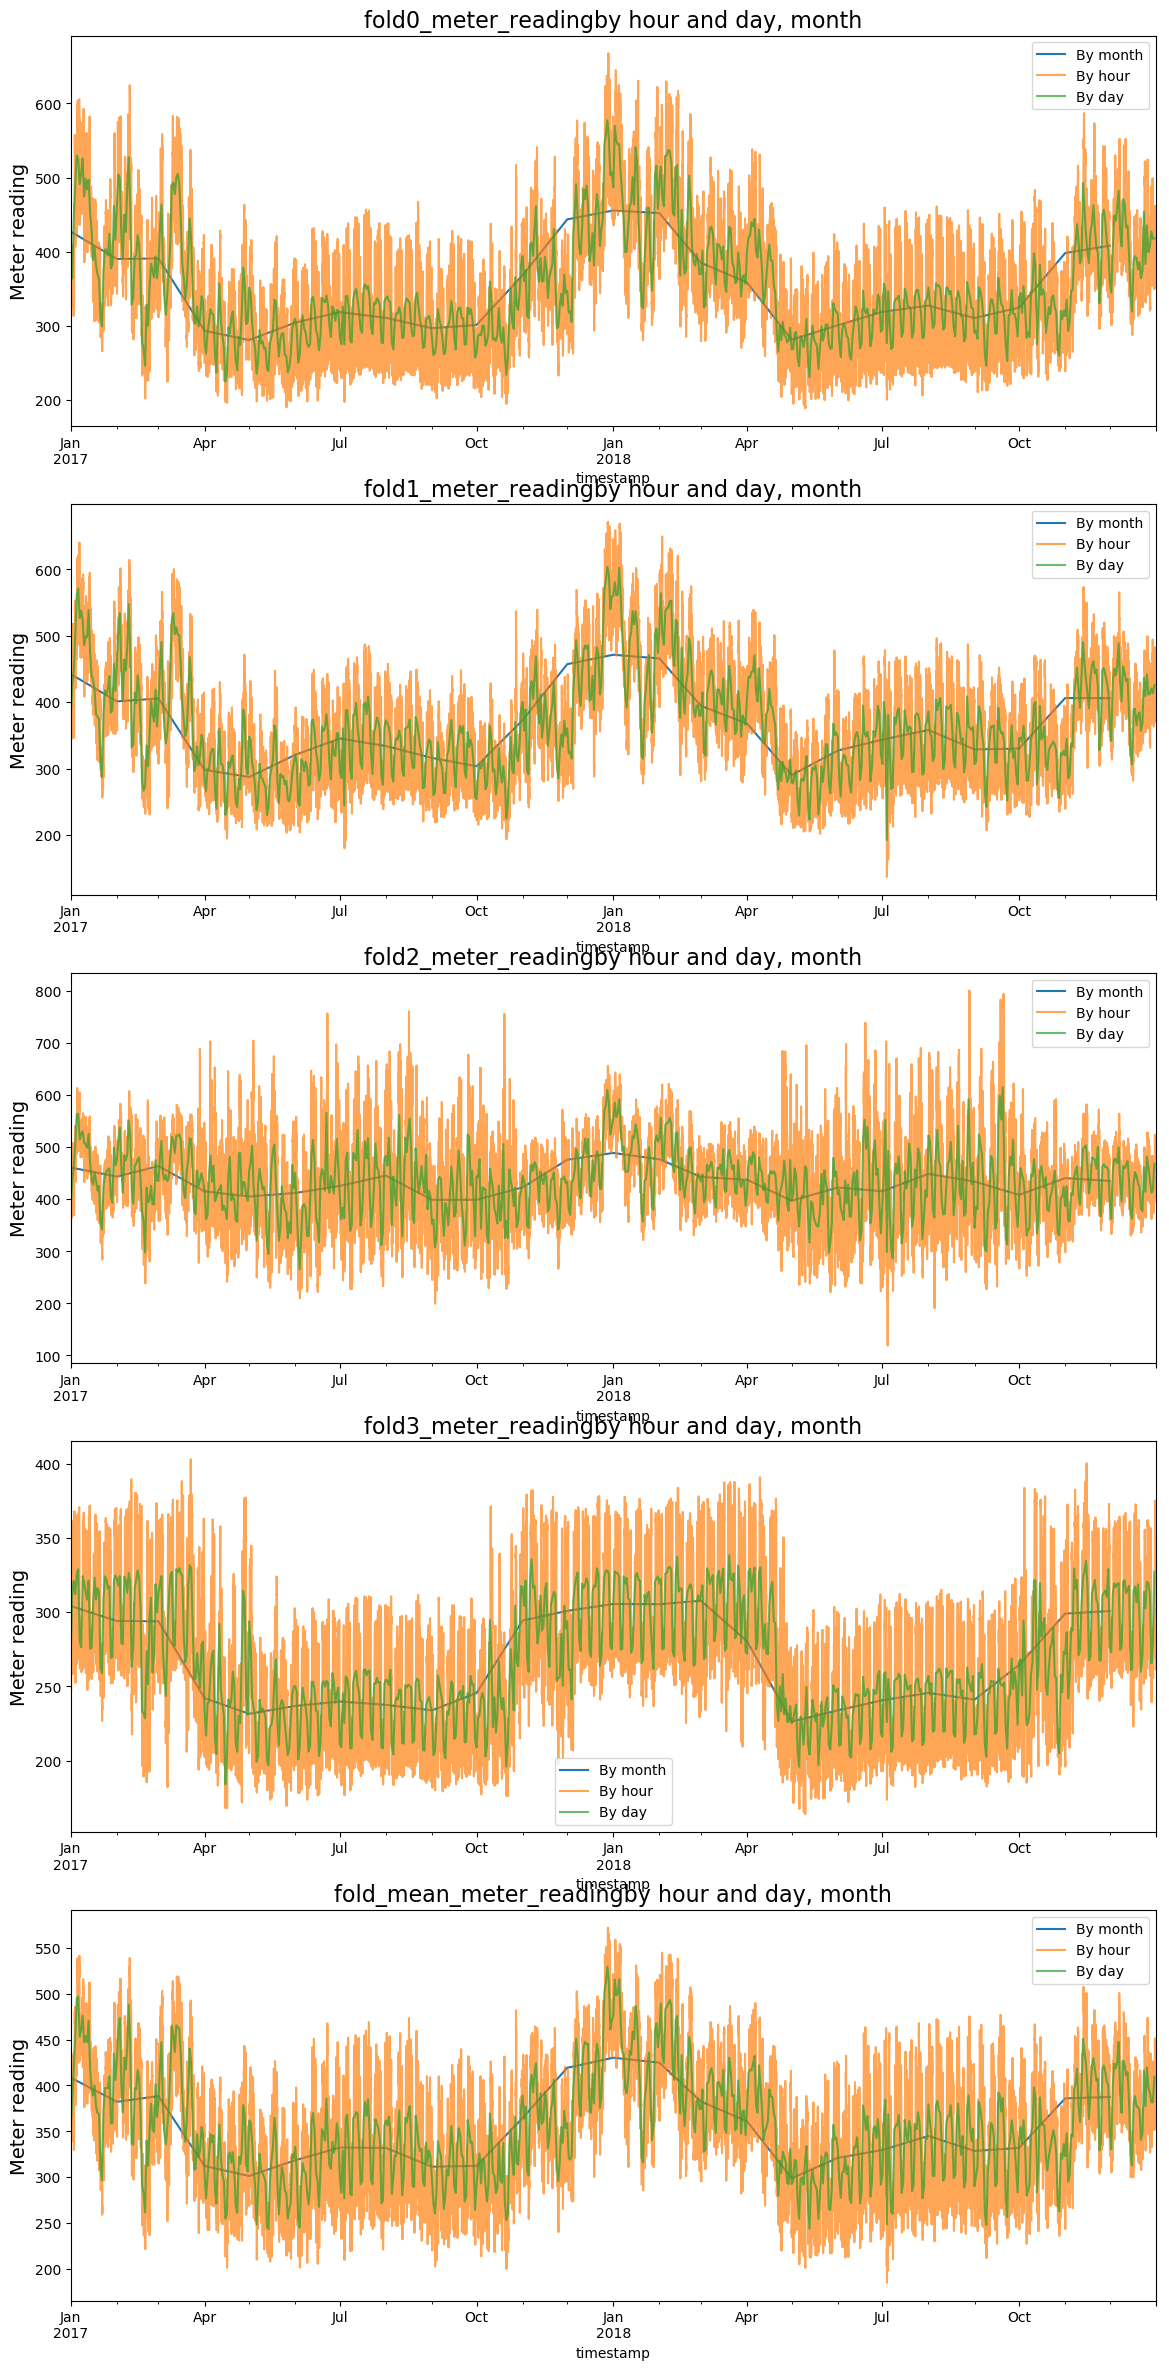

In [12]:
column = ['fold0_meter_reading', 'fold1_meter_reading','fold2_meter_reading', 'fold3_meter_reading','fold_mean_meter_reading']
fig, axes = plt.subplots(5, 1, figsize=(14, 30), dpi=100)
for i, col in enumerate(column):
    fold4[['timestamp', col]].set_index('timestamp').resample('M').mean()[col].plot(ax=axes[i], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    fold4[['timestamp', col]].set_index('timestamp').resample('H').mean()[col].plot(ax=axes[i], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    fold4[['timestamp', col]].set_index('timestamp').resample('D').mean()[col].plot(ax=axes[i], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i].legend();
gc.collect()

## fold0_predict by meter

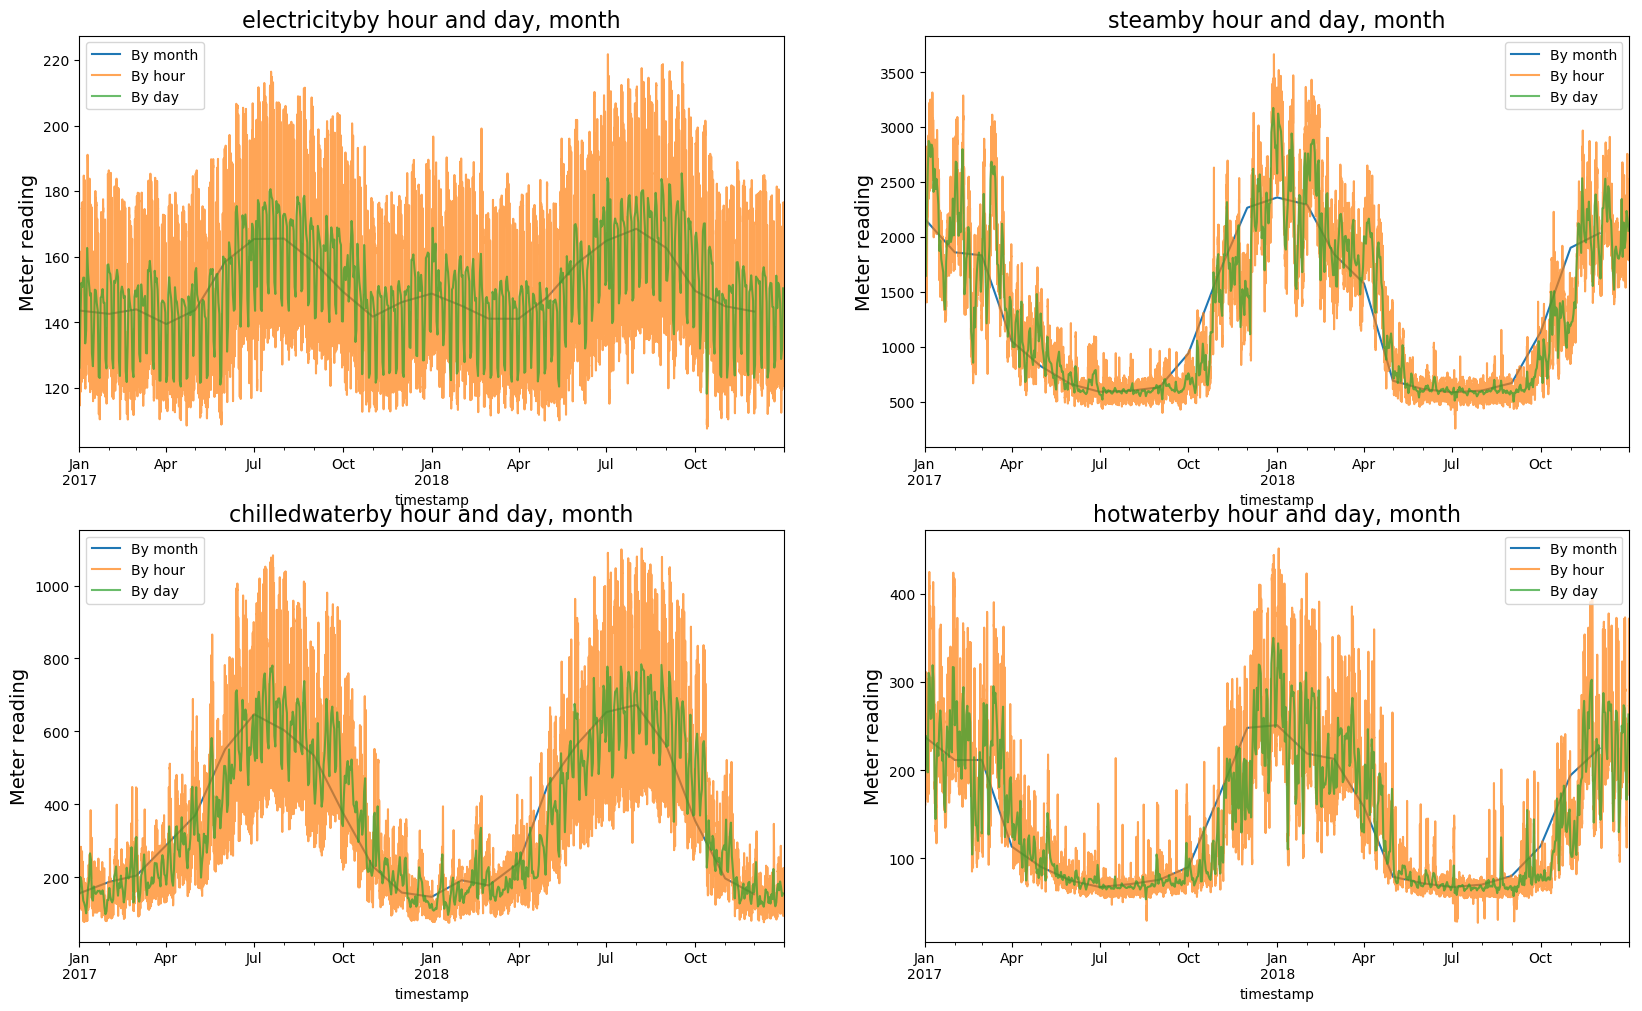

In [13]:
fold4 = pd.concat([fold4,df_test],axis=1)
fold4['meter'] = fold4['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
column = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold4[fold4['meter']==col].copy()
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('M').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('H').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold0_meter_reading']].set_index('timestamp').resample('D').mean()['fold0_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold1_predict by meter

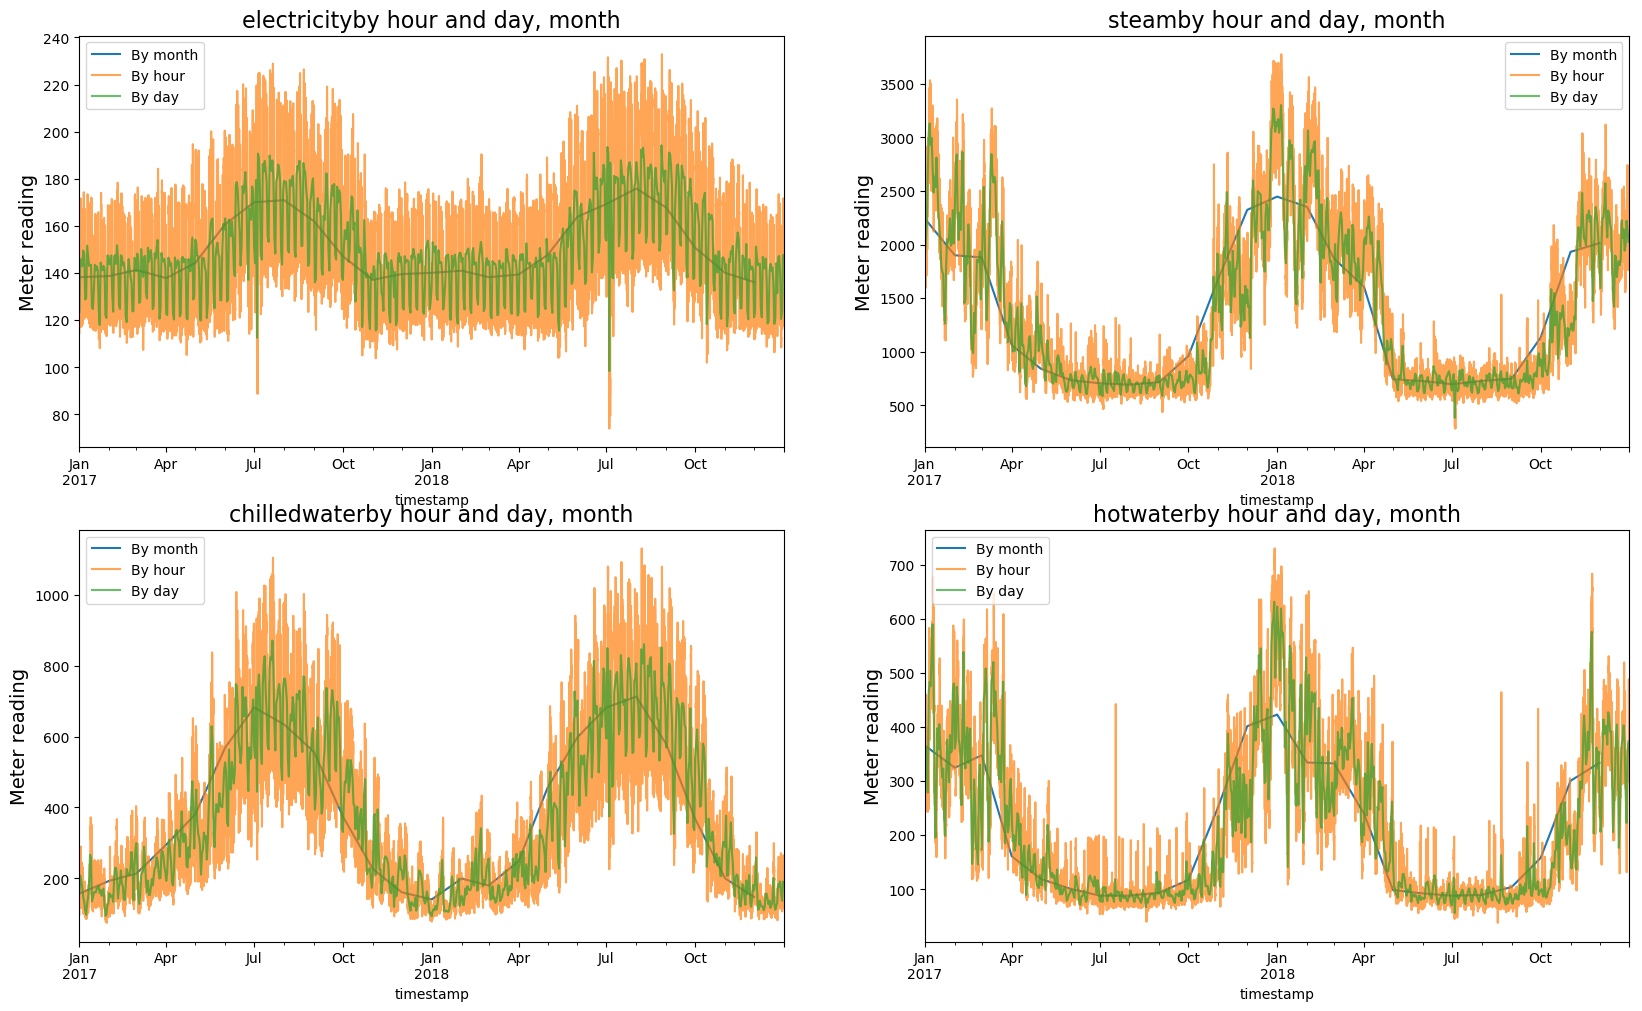

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold4[fold4['meter']==col].copy()
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('M').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('H').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold1_meter_reading']].set_index('timestamp').resample('D').mean()['fold1_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold2_predict by meter

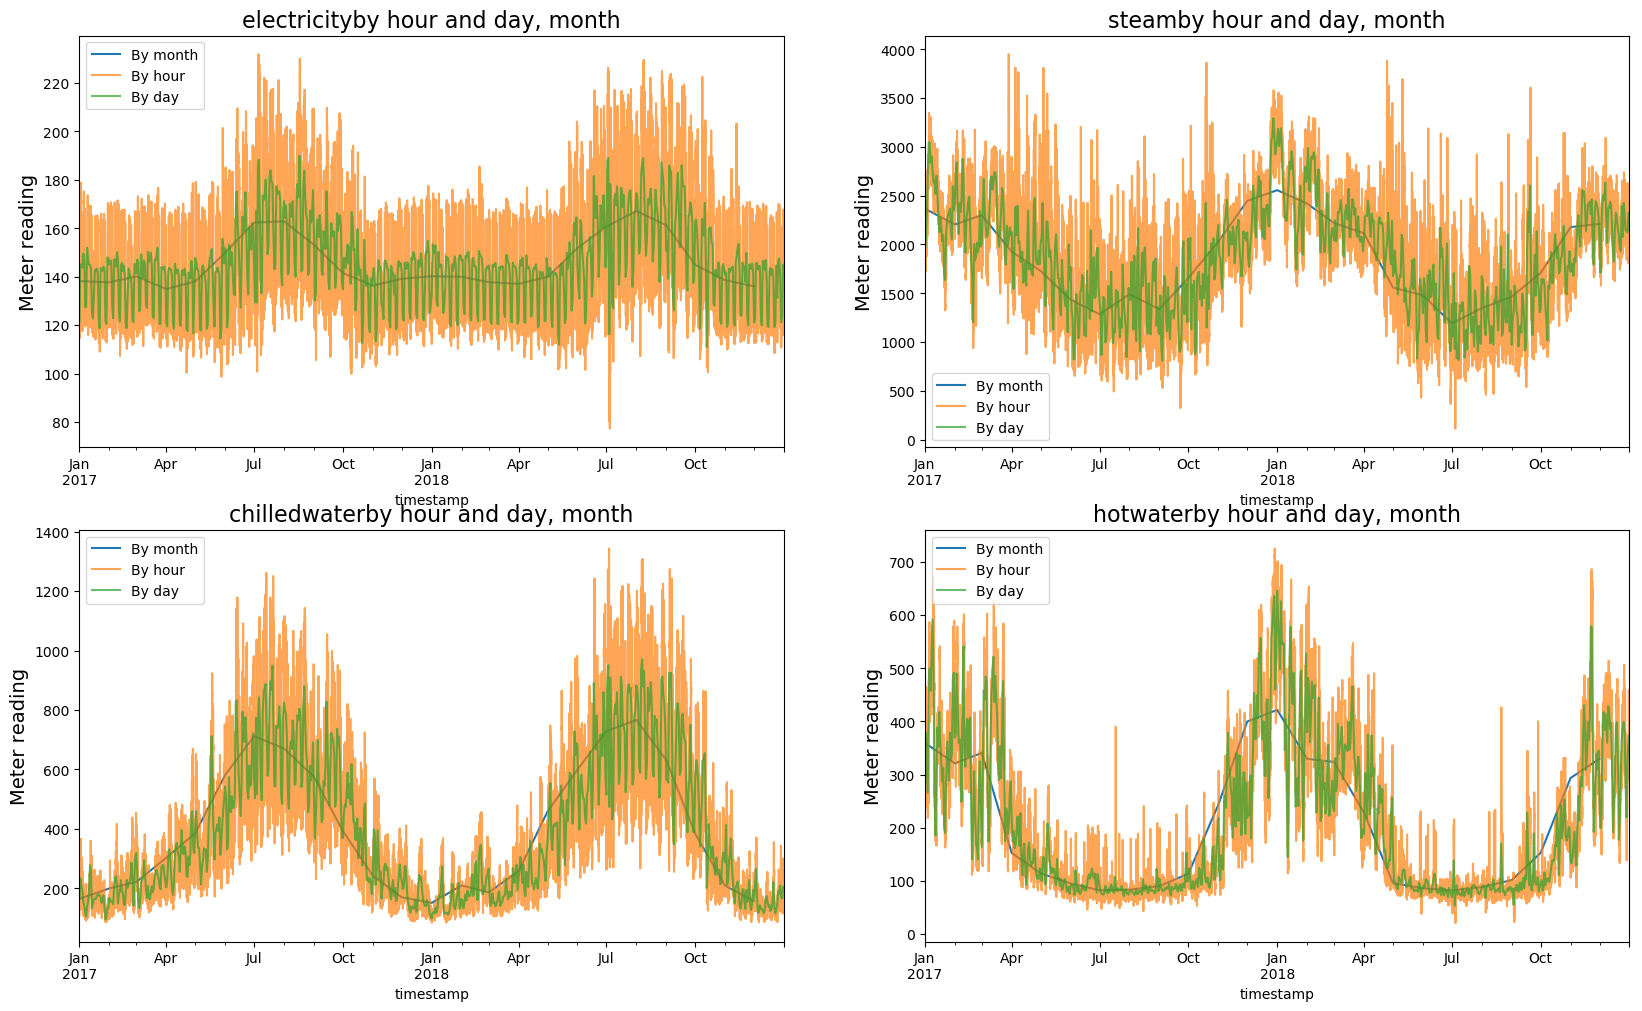

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold4[fold4['meter']==col].copy()
    train[['timestamp', 'fold2_meter_reading']].set_index('timestamp').resample('M').mean()['fold2_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold2_meter_reading']].set_index('timestamp').resample('H').mean()['fold2_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold2_meter_reading']].set_index('timestamp').resample('D').mean()['fold2_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold3_predict by meter

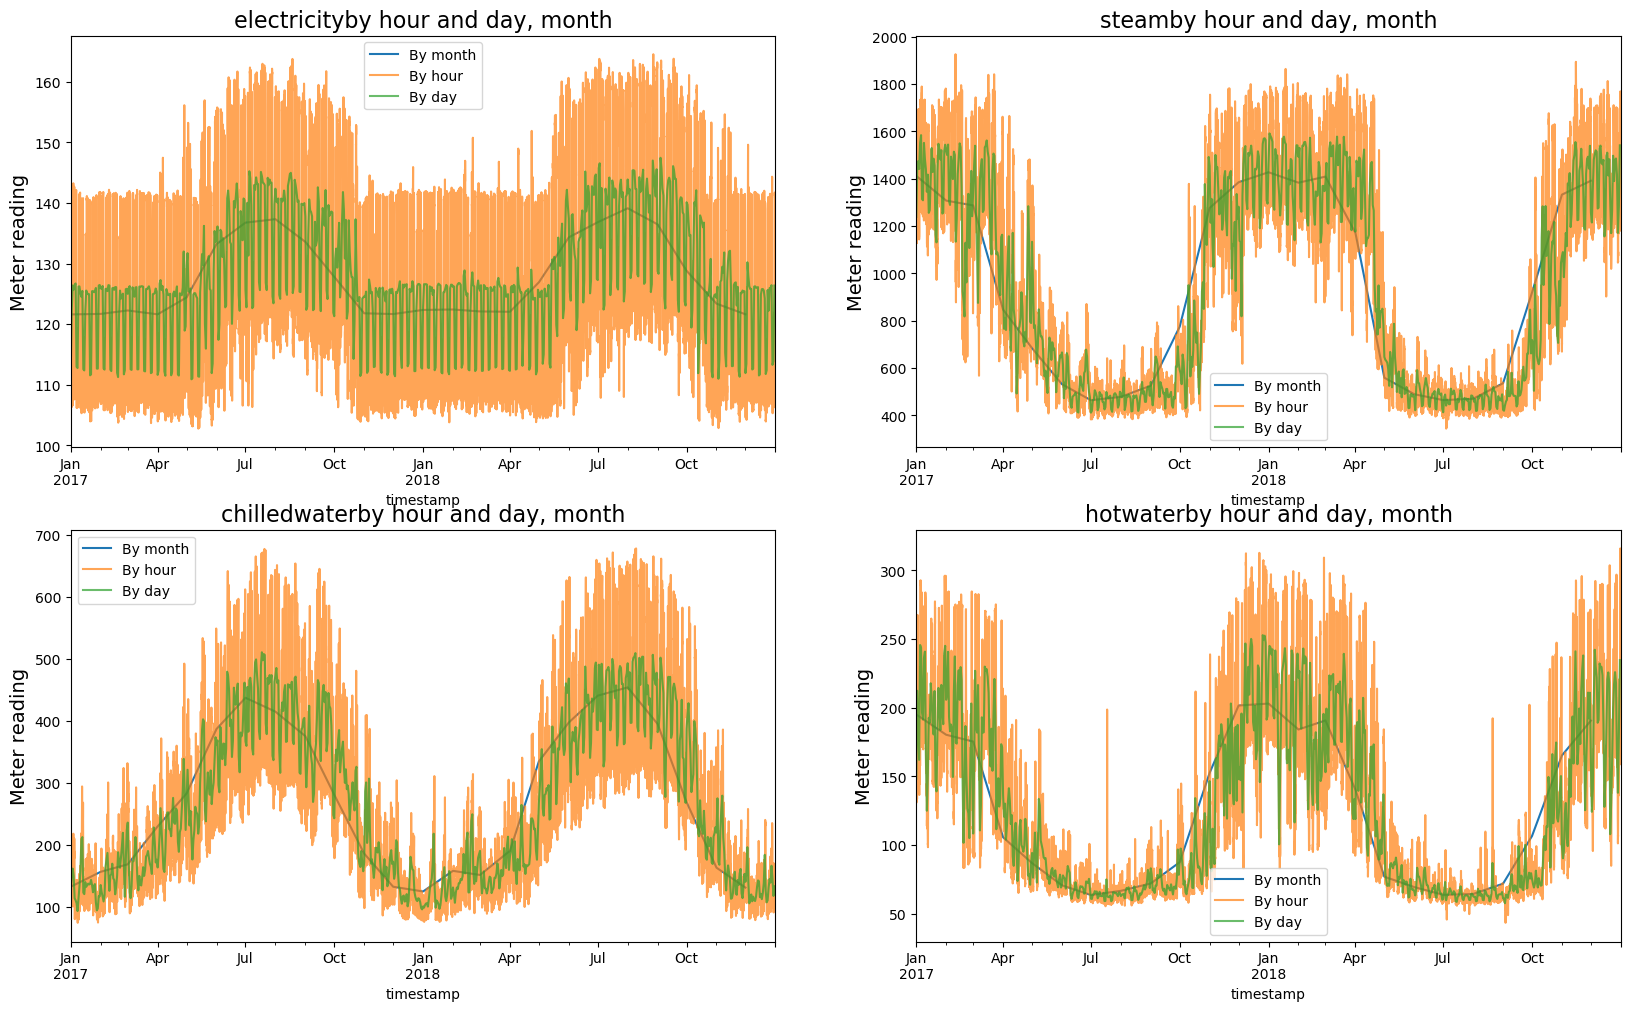

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold4[fold4['meter']==col].copy()
    train[['timestamp', 'fold3_meter_reading']].set_index('timestamp').resample('M').mean()['fold3_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold3_meter_reading']].set_index('timestamp').resample('H').mean()['fold3_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold3_meter_reading']].set_index('timestamp').resample('D').mean()['fold3_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

## fold_mean_predict by meter

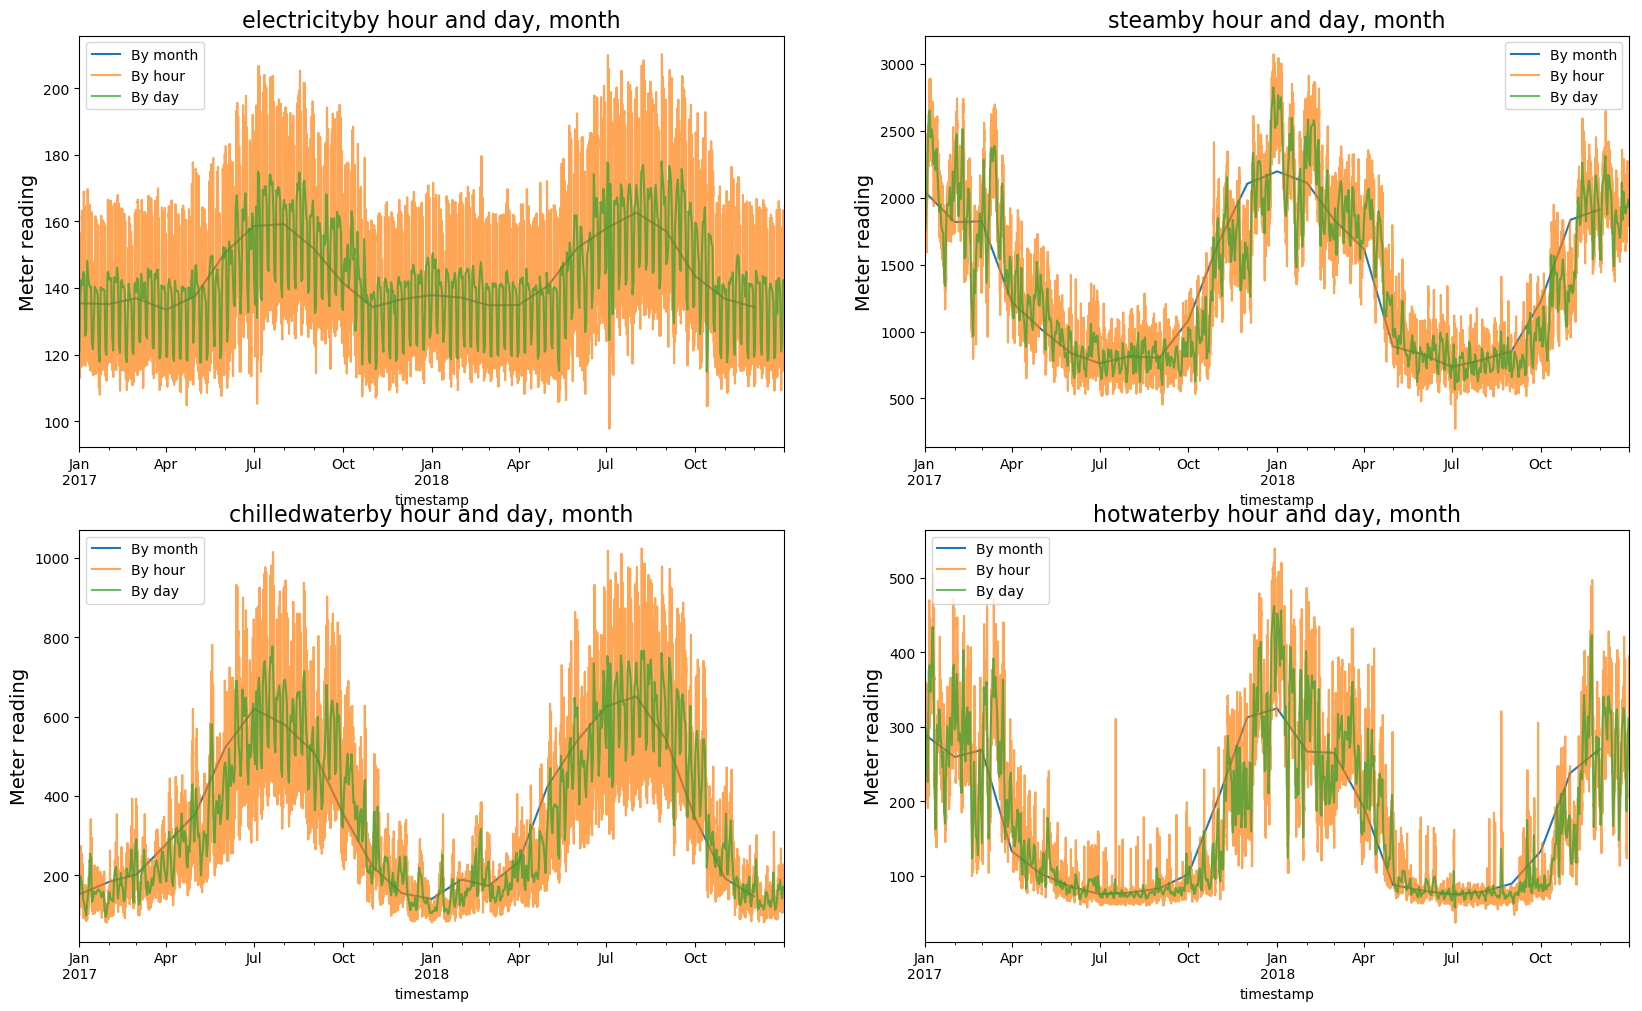

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=100)
for i, col in enumerate(column):
    train = fold4[fold4['meter']==col].copy()
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('M').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By month', alpha=1).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('H').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By hour', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    train[['timestamp', 'fold_mean_meter_reading']].set_index('timestamp').resample('D').mean()['fold_mean_meter_reading'].plot(ax=axes[i%2][i//2], label='By day', alpha=0.7).set_ylabel('Meter reading', fontsize=14);
    axes[i%2][i//2].set_title(col + 'by hour and day, month', fontsize=16);
    axes[i%2][i//2].legend();

# thinking
at the above picture January to March is a moderate MMR(Mean Meter Reading) but a very high MMR from March to July, then July to Desember shows almost zero, although it is increasing at November

- 2-Fold recorded the highest public lb(1.11); fold0 train until June before MMR falls, and fold1 train after that, then averages two results I don't know exactly, but I think this training affected model performance

- i'll test 2-fold at a reduced timestamp.

- Depending on the variable, the method of cross-validation can also be affected.

- Predictive Mean meter reading is too low for training Mean meter reading because The mean meter reading by meter type has a large difference in value. Therefore, I think that if you perform proper k-fold verification by meter, you will get a good score.

# Reference
- https://www.kaggle.com/nroman/eda-for-ashrae
- https://www.kaggle.com/ryches/simple-lgbm-solution
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113286#latest-654648



# I'll try
I'm going to try various cross-validations and upload them to the kernel. If you have idea, please mention it
- additional variable
- k-fold per site_ID, meter, Buiding_id
- 2-fold at a reduced timestamp



# Try
- [4-kfold by site ID](https://www.kaggle.com/kimtaegwan/lgbm-baseline-what-s-your-cv-method?scriptVersionId=22377656) Public LB : 2.50
- [GROUP(Month) K-Fold](https://www.kaggle.com/kimtaegwan/what-s-your-cv-method?scriptVersionId=22905017) Public LB :1.10
- train_test_spilt 
      test_size:0.5(Public LB :1.23)
      test_size:0.1(Public LB :1.22)